# Analisis_Masivo_Entrevistas_PDET.ipynb

In [1]:
## 1. Configuración inicial
import os
import pandas as pd
import numpy as np
import re
import glob
import nltk
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
## 2. Carga masiva de archivos `.txt` (Cap. 4.3 - Registro y Sistematización)
ruta = '/content/drive/MyDrive/_Luz Stella Doctorado/Mario Chamie Mazzilli/1_Audios_Archivos .m4a/Prueba_Piloto_2'

# Define la ruta por defecto
import os
os.chdir(ruta)

archivos = glob.glob(os.path.join(ruta, "*.txt"))
data = []
for archivo in archivos:
    with open(archivo, 'r', encoding='utf-8') as f:
        contenido = f.read()
        data.append({'archivo': os.path.basename(archivo), 'texto': contenido})
df = pd.DataFrame(data)
df.head()

,archivo,texto
0,Voz 036.txt,Formulario de entrevistas se mistrucuturada c...
1,Voz 035_medium.txt,Esta es nuestra primera entrevista con un alt...
2,Voz_Prueba_Piloto_01.txt,Formulario de entrevista se me estructurada a...


In [6]:
## 3. Limpieza de texto y tokenización (Cap. 5.1 - Codificación abierta)
from nltk.corpus import stopwords
stop_words = set(stopwords.words('spanish'))
def limpiar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r'[^a-záéíóúñ\s]', '', texto)
    palabras = texto.split()
    palabras = [p for p in palabras if p not in stop_words and len(p) > 2]
    return " ".join(palabras)
df['limpio'] = df['texto'].apply(limpiar_texto)

In [7]:
## 4. 3.2.1 Análisis Cuantitativo (Cap. 5.2 - Frecuencias y Sentimientos)
# Frecuencia de términos
vectorizador = CountVectorizer(max_df=0.85, min_df=2)
matriz = vectorizador.fit_transform(df['limpio'])
palabras = vectorizador.get_feature_names_out()
frecuencias = np.array(matriz.sum(axis=0)).flatten()
top = pd.DataFrame({'termino': palabras, 'frecuencia': frecuencias})
top.sort_values('frecuencia', ascending=False).head(20)

,termino,frecuencia
142,municipal,15
158,pedet,14
79,espacios,13
144,nivel,13
38,comunidad,13
31,claro,13
119,iniciativas,11
22,cada,11
202,tener,11
100,hacer,10


# Análisis de sentimientos
def sentimiento(texto):
    blob = TextBlob(texto)
    return blob.sentiment.polarity
df['sentimiento'] = df['texto'].apply(sentimiento)
sns.histplot(df['sentimiento'], kde=True)
plt.title('Distribución de Sentimientos')
plt.xlabel('Polaridad')
plt.ylabel('Frecuencia')
plt.show()

In [8]:
## 5. 3.2.2 Análisis Cualitativo (Cap. 5.1 - Codificación axial y temática)
# Modelado de tópicos con LDA
lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(matriz)
for idx, topic in enumerate(lda.components_):
    palabras_clave = [palabras[i] for i in topic.argsort()[-10:]]
    print(f"Tópico {idx+1}: {', '.join(palabras_clave)}")

Tópico 1: daba, dice, dieron, partir, queríamos, quinta, persona, pesos, tercera, verdad
Tópico 2: daba, dice, dieron, partir, queríamos, quinta, persona, pesos, tercera, verdad
Tópico 3: proponer, cambio, rol, procesos, baja, cuál, compartir, libertad, pues, comunidad
Tópico 4: hacer, parte, mujeres, doctor, ejercicio, cada, iniciativas, herramientas, tener, claro
Tópico 5: manera, espacio, proyectos, asegurar, diálogo, prioridades, espacios, pedet, nivel, municipal


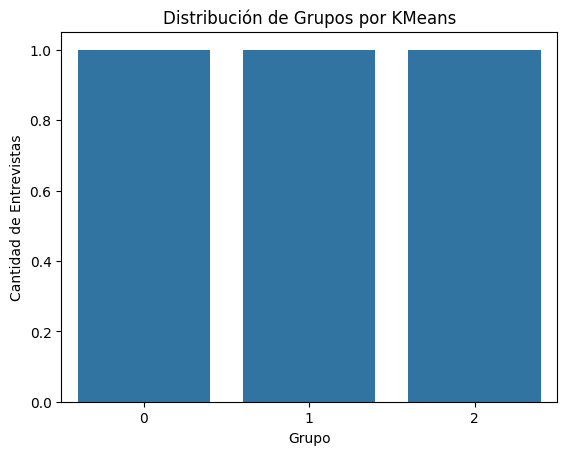

In [9]:
## 6. 3.2.3 Triangulación de fuentes y perspectivas (Cap. 5.3)
# Clustering temático con KMeans
# kmeans = KMeans(n_clusters=4, random_state=0)
kmeans = KMeans(n_clusters=3, random_state=0) # Changed n_clusters from 4 to 3 because the number of samples (3) is less than 4.
etiquetas = kmeans.fit_predict(matriz)
df['grupo'] = etiquetas
sns.countplot(x='grupo', data=df)
plt.title('Distribución de Grupos por KMeans')
plt.xlabel('Grupo')
plt.ylabel('Cantidad de Entrevistas')
plt.show()

In [11]:
from textblob import TextBlob

def sentimiento(texto):
    blob = TextBlob(texto)
    return blob.sentiment.polarity

df['sentimiento'] = df['texto'].apply(sentimiento)

# Nube de palabras por grupo
for grupo in df['grupo'].unique():
    texto = " ".join(df[df['grupo'] == grupo]['limpio'])
    wc = WordCloud(width=800, height=300).generate(texto)
    plt.figure()
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Nube de palabras - Grupo {grupo}')
    plt.show()

In [13]:
# Define la ruta por defecto
import os
ruta = '/content/drive/MyDrive/_Luz Stella Doctorado/Mario Chamie Mazzilli/1_Audios_Archivos .m4a/Prueba_Piloto_2'
os.chdir(ruta)
## 7. Exportación de resultados (Cap. 6.3 - Proyecciones para el análisis final)
df[['archivo', 'grupo', 'sentimiento']].to_csv("resumen_entrevistas_codificadas.csv", index=False)
top.to_csv("frecuencias_terminos.csv", index=False)